# Wheel Speed Sensor DSP

In [17]:
# Import functions and libraries
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
import scipy.io.wavfile as wavfile
import scipy.signal as signal
from matplotlib.pyplot import *
%matplotlib inline

The data is stored as CSV files (of a few different sample rates and bit depths) in data/. Looking at a slice, it is roughly a square wave with a lot of noise. One standard way to perform frequency analysis is to use the short time fourier transform (Hanning + DFT) and then choose the first spectral peak:

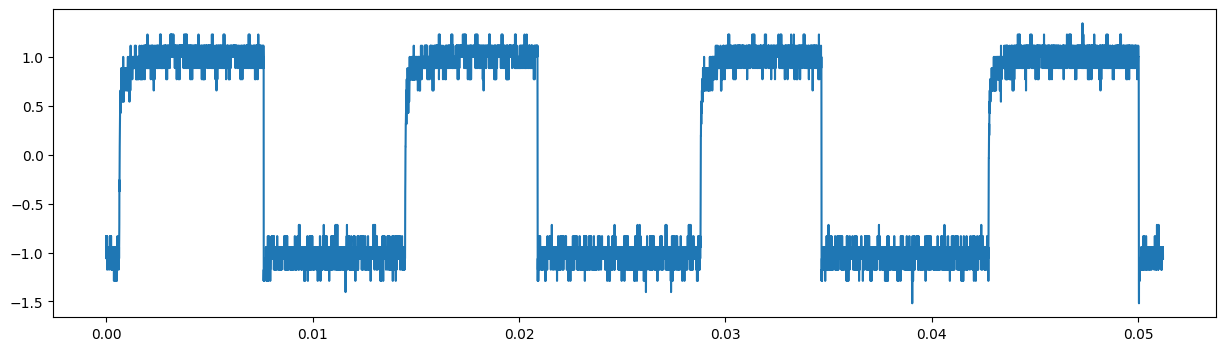

In [49]:
file_path = "data/SDS00002.csv"
data = np.loadtxt(file_path, delimiter=',', skiprows=12)
sig = data[:, 1]
sig = (sig - np.mean(sig)) / np.std(sig)
time = data[:, 0]
plt.figure(figsize=(15, 4))

plt.plot(time[:12800], sig[:12800])

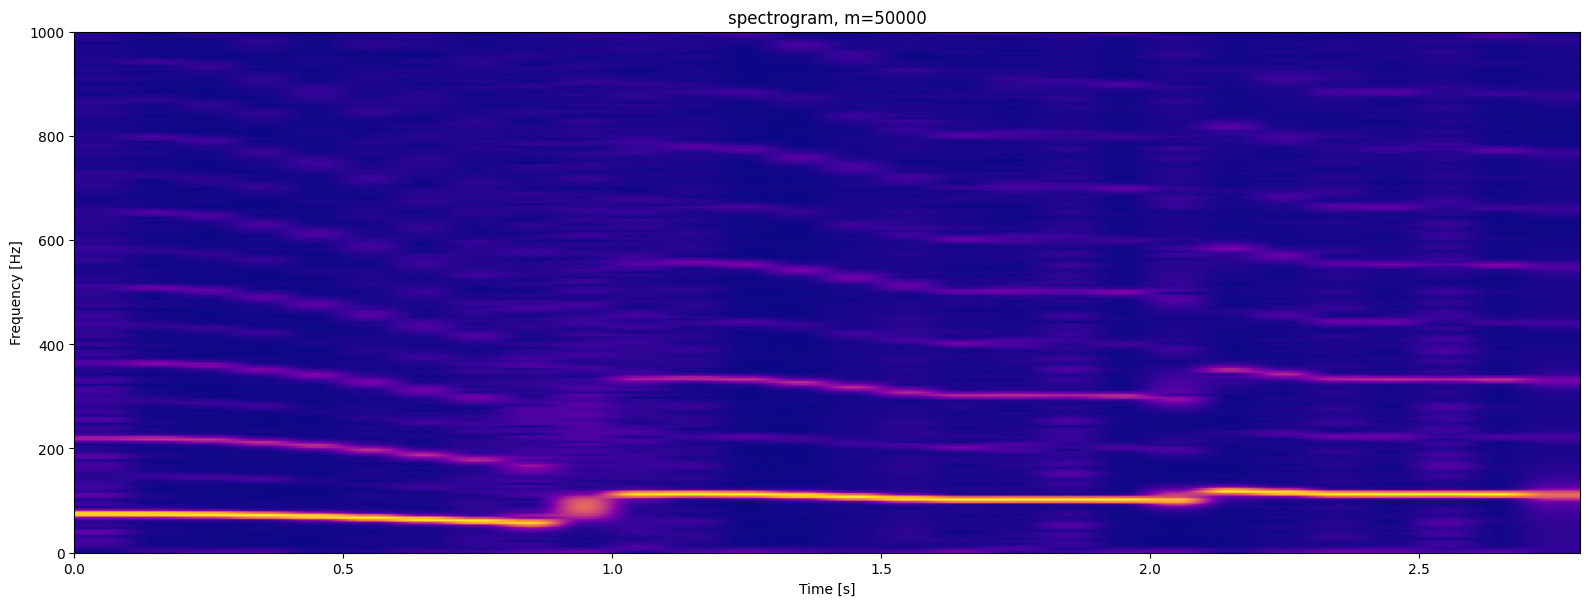

In [142]:
def sg_plot(t_range, f_range, y, dbf=10, fig=None):
    """
    Plot an image of the spectrogram of y, with the axes labeled with time tl and frequency fl

    t_range -- time axis label, nt samples
    f_range -- frequency axis label, nf samples
    y -- spectrogram, (nf x nt) array
    dbf -- dynamic range of the spectrum in dB
    """
    eps = 10.0 ** ( -dbf / 20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10((abs(y) / y_max) * (1 - eps) + eps)
    
    # rescale image intensity to 256
    img = 256 * (y_log + dbf) / dbf - 1
    if fig is None:
        fig = plt.figure(figsize=(16, 6))
    plt.imshow(np.flipud(64.0 * (y_log + dbf) / dbf ), extent=t_range  + f_range, cmap='plasma', aspect='auto')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.ylim(0, 1000)
    plt.tight_layout()

    return fig

def myspectrogram_hann_ovlp(x, m, fs):
    """
    Plot the spectrogram of x with 50% overlap using Hann window.
    
    First, the original signal x is split into 50% overlapping blocks of length m.
    Then, a Hann window is applied to each block, followed by FFT, and plotting.
    """
    # pad x to ensure that all blocks fit even with the overlap
    lx = len(x)
    step = m // 2  # Step size for 50% overlap
    nt = (lx + m - 1) // m
    padded_length = nt * 2
    x_padded = append(x, zeros(nt * m - lx + step))
    # x_padded = append(x,zeros(-lx+nt*m))
    # calculate the number of blocks, considering the overlap
    # nt = (lx - m) // step + 1
    # padded_length = step * nt + m
    # x_padded = append(x, zeros(padded_length - lx))
    
    # Initialize an empty list to store the blocks
    xm = np.zeros((m, padded_length))
    
    # Fill xm with 50% overlapping blocks
    for i in range(padded_length):
        xm[:, i] = x_padded[i * step:i * step + m]
    
    xmw = xm * hanning(m)[:, None] # np.kaiser(m, 7)[:, None] # hann_window[:, None]
    
    # FFT for each block
    xmf = fft(xmw, axis=0)
    frequency_axis = np.linspace(0, fs, m, endpoint=False)

    # Calculate the magnitude of the FFT for each block
    xmf_mag = np.abs(xmf)
    
    # Initialize arrays to store the peak frequency and magnitude for each block
    peak_frequencies = np.zeros(padded_length)
    peak_magnitudes = np.zeros(padded_length)
    
    # Iterate through each block to find the spectral peak
    for i in range(padded_length):
        # Find the index of the maximum magnitude in this block's FFT
        peak_index = np.argmax(xmf_mag[:1000, i])
        # Store the peak frequency and its magnitude
        peak_frequencies[i] = frequency_axis[peak_index]
        peak_magnitudes[i] = xmf_mag[peak_index, i]
    
    # Time vector for each block
    time_vector = np.arange(padded_length) * step / fs
    
    # Plot the peak frequencies over time

    # New time vector calculation to account for the overlap in time samples

    f_range = [0.0, fs / 2]
    # Total duration covered by all blocks, accounting for overlap
    # Note: The last block doesn't start at the end, so we subtract one step and add one block duration
    # t_range = [0.0, (padded_length - 1) * step / fs]
    t_range = [0.0, lx / fs]

    # t_range = [0.0, total_duration]
    # Assuming sg_plot is defined elsewhere and capable of plotting the spectrogram
    fig = sg_plot(t_range, f_range, xmf[0:m // 2, :])
    
    return time_vector, peak_frequencies  # Placeholder return statement


m = 50000
fs = 250000
time_vector, peak_frequencies = myspectrogram_hann_ovlp(sig[::], m, fs)
plt.title(f"spectrogram, m={m}")
plt.show()

# b, a = signal.butter(5, normalized_cutoff, btype='low')

# # Apply the filter to the signal
# filtered_signal = lfilter(b, a, signal)

# # Downsample the signal
# downsampled_signal = decimate(filtered_signal, decimation_factor, ftype='fir', zero_phase=True)

We can clearly see the dominant spectral component around 75Hz, going up as the wheel is spun more, and gradually slowing down. However, getting this in to run real time on an STM32 would probably be a little painful so an alternate (but slightly worse) way is to just detect zero crossings:

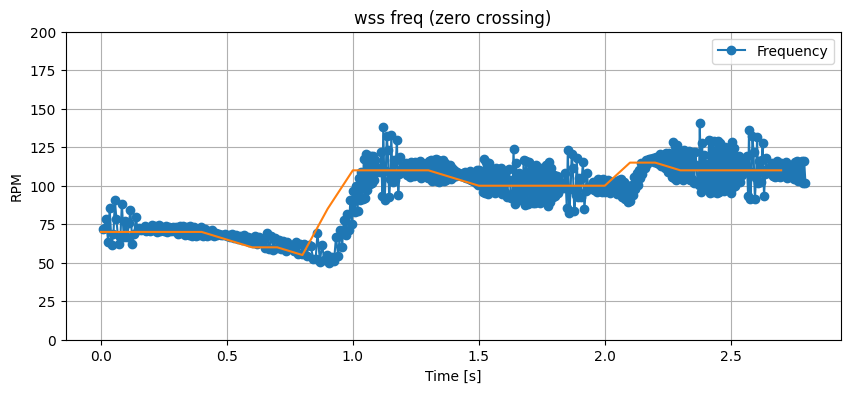

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the zero crossings and derive frequency
def calculate_zero_crossings(signal, time):
    # Find the zero-crossing points (where the signal changes sign)
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    times_of_crossings = time[zero_crossings]
    # Calculate the periods from the diffs of the times of crossings
    # We double the diffs as a full period will include two crossings for a square wave
    periods = np.diff(times_of_crossings) * 2
    frequencies = 1 / periods

    threshold = 500
    valid_freqs = frequencies[frequencies < threshold]
    valid_times = times_of_crossings[1:][frequencies < threshold]

    return valid_times, valid_freqs

# Plotting function for the frequency vs time
def plot_frequency_vs_time(time, frequency):
    plt.figure(figsize=(10, 4))
    
    # fast way to implement a simple moving average filter (can try different values of window for more or less smoothing)
    window_size = 2
    window = np.ones(int(window_size))/float(window_size)
    fs = np.convolve(frequency, window, 'same')
    trim = len(window) - 1

    plt.plot(time[:], frequency, marker='o', linestyle='-', label='Frequency')
    plt.plot(time_vector, peak_frequencies)
    plt.title('wss freq (zero crossing)')
    plt.xlabel('Time [s]')
    plt.ylim(0, 200)
    plt.ylabel('RPM')
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming signal and time are loaded from your CSV and are NumPy arrays
midpoints, frequencies = calculate_zero_crossings(sig, time)
# 84 hz per rev * 60 s /min
plot_frequency_vs_time(midpoints, frequencies)


This works pretty well and we can do some more math to get the actual wheel RPM (don't trust the values I don't know the actual number of teeth/rev.

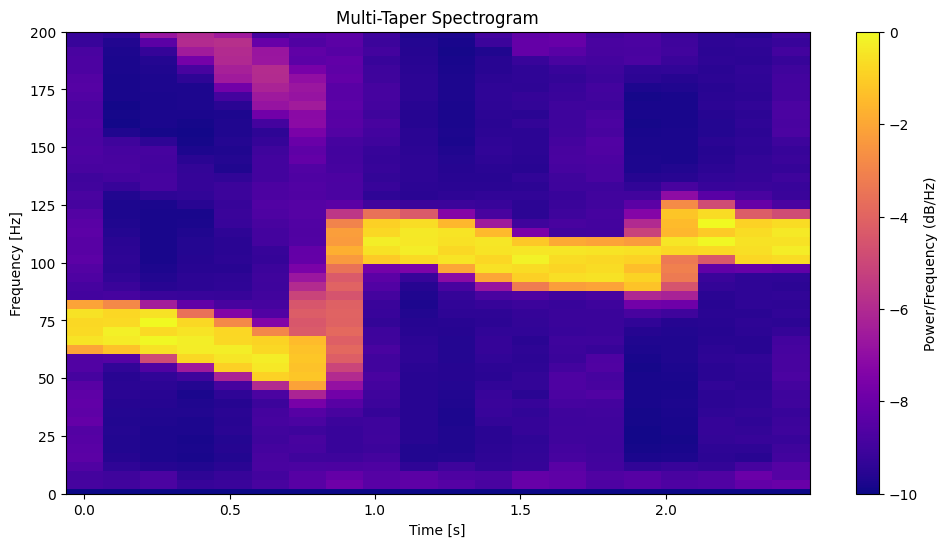

<module 'matplotlib.pyplot' from '/home/krishna/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, get_window

def myspectrogram_multitaper(x, m, fs, n_tapers=5, dbf=10):
    """
    Plot the spectrogram of x using the Multi-Taper method for improved spectral estimation.

    Parameters:
    - x: Input signal array.
    - m: Window length for the FFT and each taper.
    - fs: Sampling frequency of x.
    - n_tapers: Number of DPSS (Slepian) tapers to use.

    Returns:
    - A matplotlib figure showing the spectrogram.
    """
    # Generate DPSS (Slepian) tapers
    from scipy.signal.windows import dpss
    tapers = dpss(m, NW=3, Kmax=n_tapers, sym=False)  # NW is the time-halfbandwidth product

    # 50% overlap
    step = m // 2
    nt = (len(x) - m) // step + 1  # Calculate number of time steps
    times = np.arange(nt) * step / fs  # Time for each slide

    # Pre-allocate spectrum matrix
    spectrum = np.zeros((m // 2 + 1, nt))

    # Process each segment with all tapers
    for i in range(nt):
        segment_start = i * step
        segment_end = segment_start + m
        if segment_end > len(x):
            break  # Avoid going out of bounds
        segment = x[segment_start:segment_end]
        
        # Apply each taper to the segment and average the spectral power
        tapered_spectra = np.zeros((m // 2 + 1, n_tapers))
        for k in range(n_tapers):
            tapered_signal = segment * tapers[k]
            f, t, Sxx = spectrogram(tapered_signal, fs=fs, window='boxcar', nperseg=m, noverlap=0, nfft=m, mode='magnitude')
            tapered_spectra[:, k] = np.mean(Sxx, axis=1)
        
        # Average across all tapers
        spectrum[:, i] = np.mean(tapered_spectra, axis=1)
    eps = 10.0 ** ( -dbf / 20.0)  # minimum signal
    
    # find maximum
    s_max = abs(spectrum).max()
    
    # compute 20*log magnitude, scaled to the max
    s_log = 20.0 * np.log10((abs(spectrum) / s_max) * (1 - eps) + eps)
    # Plotting the spectrogram
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(times, f,s_log, shading='auto', cmap='plasma')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.ylabel('Frequency [Hz]')
    plt.ylim(0, 200)
    plt.xlabel('Time [s]')
    plt.title('Multi-Taper Spectrogram')
    plt.show()

    return plt  # Return the plot object for further manipulation if necessary

# Example usage
# x is your signal, m is the window size, fs is the sampling rate
myspectrogram_multitaper(sig, 64000, fs)